In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import datetime
import warnings
warnings.filterwarnings("ignore")

# Not Public Libraries
from bletchley import Bletchley
from forge import TheForge

### Research
____

In [3]:
# Create Bletchley object
# Strat Name = EXWIFE
# for BANKNIFTY OTM100 9.20 CE/PE contracts
# 15 minutes
bletchley = Bletchley("EXWIFE", ["BANKNIFTY_920_OTM100_Call", "BANKNIFTY_920_OTM100_Put"], [20, 20], '15min', [0, 1, 2, 3, 4], None, 2017 )

In [13]:
bletchley.list_of_insample_raw[0].head()

,open,high,low,close,volume,time,date,weekday,rsi
datetime,,,,,,,,,
2017-01-02 09:15:00,125.05,125.60,71.2,71.20,434320.0,09:15:00,2017-01-02,0,NaN
2017-01-02 09:30:00,71.75,72.00,52.0,68.45,446000.0,09:30:00,2017-01-02,0,NaN
2017-01-02 09:45:00,68.40,69.15,58.8,58.80,236040.0,09:45:00,2017-01-02,0,NaN
2017-01-02 10:00:00,58.80,63.20,57.0,59.80,126520.0,10:00:00,2017-01-02,0,NaN
2017-01-02 10:15:00,59.65,64.50,58.0,59.35,124280.0,10:15:00,2017-01-02,0,NaN


In [166]:
# Create new feature 
# RSI of close values, 20 period
bletchley.create_feature("rsi_close_20", bletchley.list_of_insample_raw + bletchley.list_of_outsample_raw + bletchley.list_of_price_data_raw )

In [186]:
# Select one of the insample sets (CE or PE)
price_data = bletchley.list_of_insample_raw[1]

In [187]:
# Subset to retain only Thursday data 
price_data = price_data[price_data["weekday"] == 3]

In [188]:
# Create new feature to store change from this close to next close
price_data['change'] = price_data['close'].shift(-1) - price_data['close']

In [189]:
# Create new dataframe for predictive power analysis
pp = pd.concat([price_data['rsi'], price_data['change'], price_data['time']], axis=1)

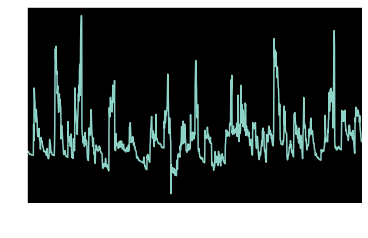

In [190]:
# Plot raw RSI values
pp['rsi'].plot(use_index=False)

In [191]:
# Transform RSI values into discrete buckets
pp['rsi'] = pp['rsi'].apply(lambda x: np.where(x < 45, -1, x))
pp['rsi'] = pp['rsi'].apply(lambda x: np.where(x > 60, 1, x))
pp['rsi'] = pp['rsi'].apply(lambda x: np.where(abs(x) == 1, x, 0))

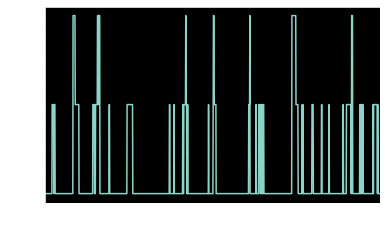

In [192]:
# Plot new RSI values
pp['rsi'].plot(use_index=False)

In [193]:
# Remove post 3.15PM data 
pp = pp[pp['time'] <= datetime.time(15, 0)]

In [194]:
# Group change values by RSI to see predicitve power
pp.groupby('rsi').sum()

,change
rsi,
-1.0,6.7
0.0,-503.8
1.0,263.0


In [195]:
# Retain only rows where new RSI is 1
pp = pp[pp['rsi'] == 1]

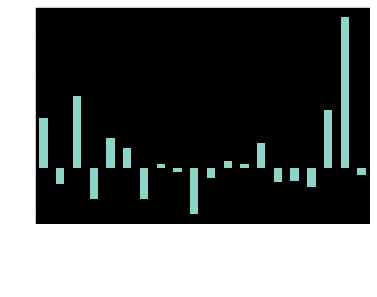

In [196]:
# Plot return distribution across timestamps
pp.groupby('time').sum()['change'].plot(kind='bar')

### Backtest ( Insample ) 
_____

In [249]:
# Create backtester object
forge = TheForge(bletchley.strat_name, bletchley.list_of_tickers, bletchley.list_of_insample_raw, bletchley.list_of_lot_sizes, False )

In [250]:
### Set Backtest Parameters

# Initial Capital
forge.initial_capital = 100000

# Risk per trade as % of pfolio
forge.risk_pfolio = 0.05

# Slippage
forge.slippage = 0.01

# Margin per lot
forge.margin_per_lot = None

# Leverage
forge.leverage = 1

In [251]:
# Buying
# above RSI 60
# after 1 PM / 1300
# close trade at 3.15 PM / 1515

buy = " (price_data['rsi'] > 60) & (price_data['time'] >= datetime.time(13, 0)) & (price_data['time'] < datetime.time(15,0)) & (price_data['weekday'] == 3)  "
sell = " price_data['time'] >= datetime.time(15, 0) "

short = "$"
cover = "$"

In [252]:
forge.generate_trade_signals(buy, sell, short, cover)

In [253]:
forge.run_backtest('%', 0.2, None, None, False, None, False)

,Value
Start Date,2017-01-02
End Date,2017-12-29
Total Returns %,153.86
Annualized Returns %,153.86
Extrapolated Annualized Returns %,153.85
Annualized Volatility %,NaN
Extrapolated Annualized Volatility %,NaN
Maximum Drawdown %,-10.37
Duration of MDD,119 Days
Avg. Holding Time,60 Min


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
2017,0,0,10.48,0,123.97,-5.27,0,0,-5.11,0,29.78,0,153.85


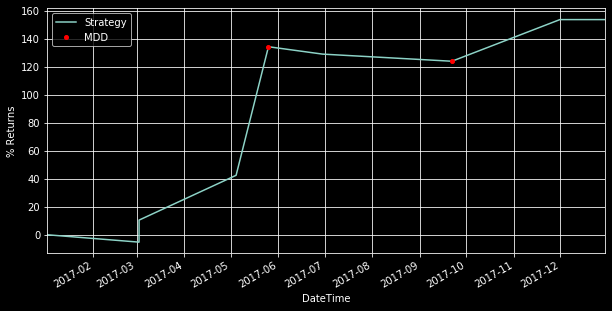

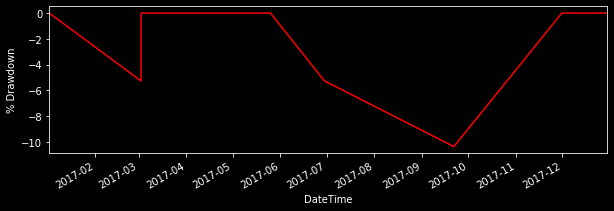

In [254]:
forge.tearsheet()

### Backtest ( Outsample ) 
_____

In [255]:
# Create backtester object
forge = TheForge(bletchley.strat_name, bletchley.list_of_tickers, bletchley.list_of_outsample_raw, bletchley.list_of_lot_sizes, False )

In [256]:
### Set Backtest Parameters

# Initial Capital
forge.initial_capital = 100000

# Risk per trade as % of pfolio
forge.risk_pfolio = 0.05

# Slippage
forge.slippage = 0.01

# Margin per lot
forge.margin_per_lot = None

# Leverage
forge.leverage = 1

In [257]:
# Buying
# above RSI 60
# after 1 PM / 1300
# close trade at 3.15 PM / 1515

buy = " (price_data['rsi'] > 60) & (price_data['time'] >= datetime.time(13, 0)) & (price_data['time'] < datetime.time(15,0)) & (price_data['weekday'] == 3)  "
sell = " price_data['time'] >= datetime.time(15, 0) "

short = "$"
cover = "$"

In [258]:
forge.generate_trade_signals(buy, sell, short, cover)

In [259]:
forge.run_backtest('%', 0.2, None, None, False, None, False)

,Value
Start Date,2016-07-04
End Date,2020-03-31
Total Returns %,123.34
Annualized Returns %,24.67
Extrapolated Annualized Returns %,35.69
Annualized Volatility %,30.69
Extrapolated Annualized Volatility %,30.18
Maximum Drawdown %,-20.47
Duration of MDD,497 Days
Avg. Holding Time,46 Min


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
2016,nan,nan,nan,nan,nan,nan,27.25,0,7.25,-3.98,0,4.35,34.87
2017,0,0,0,0,0,0,0,0,0,0,0,0,0
2018,-15.27,-4.62,0,-0.57,16.82,0,-4.86,-4.89,0,0,24.15,0,10.76
2019,1.92,0,1.57,-4.97,-4.7,51.59,11.78,17.85,-5.06,1.38,0,2.56,73.92
2020,2.71,-5.1,6.19,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.8


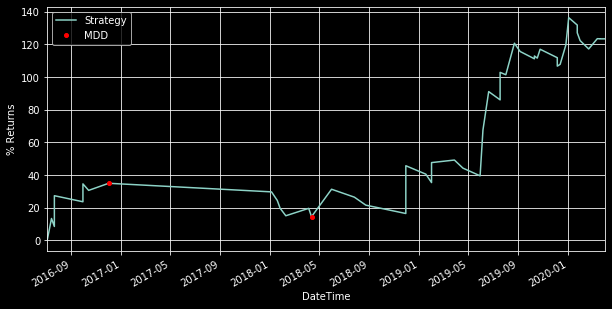

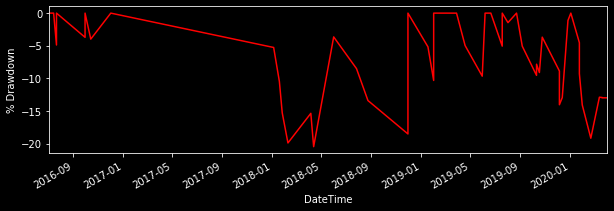

In [260]:
forge.tearsheet()

### Backtest ( All Data ) 
_____

In [261]:
# Create backtester object
forge = TheForge(bletchley.strat_name, bletchley.list_of_tickers, bletchley.list_of_price_data_raw, bletchley.list_of_lot_sizes, False )

In [262]:
### Set Backtest Parameters

# Initial Capital
forge.initial_capital = 100000

# Risk per trade as % of pfolio
forge.risk_pfolio = 0.05

# Slippage
forge.slippage = 0.01

# Margin per lot
forge.margin_per_lot = None

# Leverage
forge.leverage = 1

In [263]:
# Buying
# above RSI 60
# after 1 PM / 1300
# close trade at 3.15 PM / 1515

buy = " (price_data['rsi'] > 60) & (price_data['time'] >= datetime.time(13, 0)) & (price_data['time'] < datetime.time(15,0)) & (price_data['weekday'] == 3)  "
sell = " price_data['time'] >= datetime.time(15, 0) "

short = "$"
cover = "$"

In [264]:
forge.generate_trade_signals(buy, sell, short, cover)

In [265]:
forge.run_backtest('%', 0.2, None, None, False, None, False)

,Value
Start Date,2016-07-04
End Date,2020-03-31
Total Returns %,277.2
Annualized Returns %,55.44
Extrapolated Annualized Returns %,84.04
Annualized Volatility %,61.47
Extrapolated Annualized Volatility %,51.11
Maximum Drawdown %,-20.47
Duration of MDD,133 Days
Avg. Holding Time,48 Min


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
2016,nan,nan,nan,nan,nan,nan,27.25,0,7.25,-3.98,0,4.35,34.87
2017,0,0,10.48,0,123.97,-5.27,0,0,-5.11,0,29.78,0,153.85
2018,-15.27,-4.62,0,-0.57,16.82,0,-4.86,-4.89,0,0,24.15,0,10.76
2019,1.92,0,1.57,-4.97,-4.7,51.59,11.78,17.85,-5.06,1.38,0,2.56,73.92
2020,2.71,-5.1,6.19,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.8


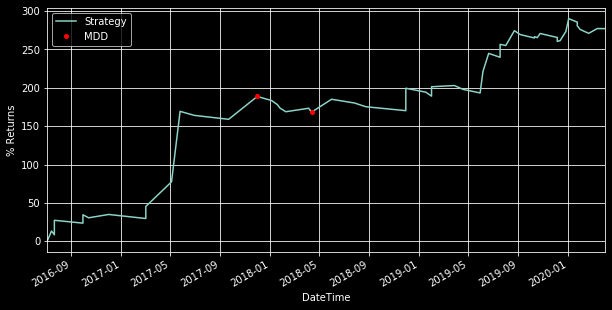

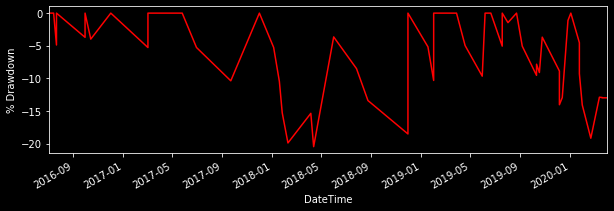

In [266]:
forge.tearsheet()